# ML-Helio Tutorial 1: Preparing data, training models, making inference

## John Armstrong, University of Glasgow
### 17/09/19, Amsterdam, NL

The following notebook will demonstrate the basics of preparing data to use for machine learning purposes; training various models using different regression methods from the [scikit-learn](https://scikit-learn.org/stable/) Python package and a neural network from the [PyTorch](https://pytorch.org); and making inference on unseen data.

The example we will use is that of predicting sunspot numbers for the next solar cycle. The sunspot number data is provided by [Royal Observatory of Belgium](http://sidc.be/silso/datafiles) and we use the data of mean monthly sunspot number. The data spans 1749&ndash;present.

The first thing to do is import all of the Python packages we will need.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, ConstantKernel
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## 1. Preparing the Data

The data we have is in csv format (it is the file `SN_m_tot_V2.0.csv`). The format of the file is as follows.

| Column number | Column contents                               |
|:-------------:|-----------------------------------------------|
|       1       | Year                                          |
|       2       | Month                                         |
|       3       | Date in fraction of year                      |
|       4       | Monthly mean total number of sunspots         |
|       5       | Monthly standard deviation                    |
|       6       | Number of observations used to calculate mean |
|       7       | Definitive/provisional marker                 |

We then want to prepare this data using the `pandas` and `numpy` Python packages:

In [2]:
ss_data = pd.read_csv("SN_m_tot_V2.0.csv", sep=";", header=None, names=["Year", "Month", "Date in fraction of year", "Monthly mean", "Monthly standard deviation", "Number of observations", "Definitive/provisional marker"])

In [3]:
ss_data.tail()

,Year,Month,Date in fraction of year,Monthly mean,Monthly standard deviation,Number of observations,Definitive/provisional marker
3243,2019,4,2019.286,9.1,0.7,896,0
3244,2019,5,2019.371,10.1,0.7,977,0
3245,2019,6,2019.453,1.2,0.7,1113,0
3246,2019,7,2019.538,0.9,0.2,1069,0
3247,2019,8,2019.623,0.7,0.2,1157,0


We can now plot the data to see what it looks like.

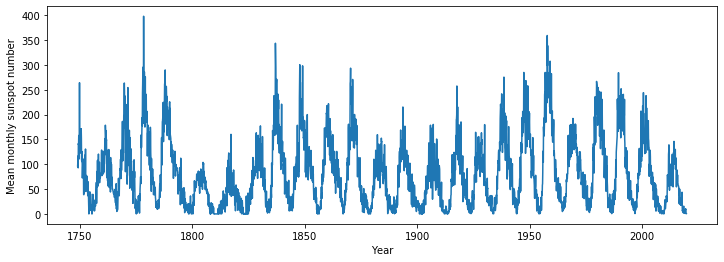

In [4]:
plt.figure(figsize=(12,4))
plt.plot(ss_data["Date in fraction of year"], ss_data["Monthly mean"])
plt.ylabel("Mean monthly sunspot number")
plt.xlabel("Year");

In [5]:
time = ss_data["Date in fraction of year"].to_numpy()
ss_number = ss_data["Monthly mean"].to_numpy()

Most ML algorithms in `scitkit-learn` require the features of the data to be standardised and distributed as the unit Gaussian. As such we use the preprocessing technique of `StandardScaler` to define a standard transformation to this ditribution which can then be inverted to return to the original system.

In [6]:
ss = StandardScaler()
ss.fit(time.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)

Now we can transform our feature (time).

In [7]:
time_ss = ss.transform(time.reshape(-1,1))

We now have prepared both the input and the output for our machine learning problem. The next thing to do is to apply some ML methods!

## 2. Applying Machine Learning Methods through Scikit-learn

The following will be a demonstration on how to use some of the regression methods from the `scikit-learn` Python package to fit our data and see if we can predict the next solar cycle.

Methods from `scikit-learn` follow the same basic recipe:

1. Initialise a class instance of the chosen algorithm
2. Use the `.fit` class method to train the algorithm
3. Use the `.predict` class method to use the trained models for prediction

Both methods we will look at to demonstrate using `scitkit-learn` for machine learning will employ what is known as the **kernel trick**.

Typically, ML algorithms need help in fitting non-linear functions. This usually comes in the form of mapping the raw data to a higher-dimensional feature space in which the fit is linear. When the higher-dimensional linear fit is found and transformed to the original data space we have our non-linear fit.

The kernel trick uses a similarity function to work in an implicit feature space without ever having to transform the data there. This allows us to calculate the inner product on this feature space and fit the non-linear function. This reduces computational complexity and is [mathematically viable](https://en.wikipedia.org/wiki/Kernel_method). For more information on what kernel to choose see [this guide](https://www.cs.toronto.edu/~duvenaud/cookbook/).

### 2.1 Support Vector Machines (SVMs)

In SVMs for regression, the hyperplane we fit to our data will be used as the function to predict future and past points in our data. This hyperplane is determined by minimising the error between the data and the predicted value to within a certain threshold. Points within the threshold are ignored for moving the position of the fit and the points closest to ± threshold are the support vectors which give more weight to changing the fit. 

An example ([source](https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff)):

![](Pictures/svr.jpeg)

In [8]:
svr = SVR(kernel=ConstantKernel(constant_value=10)*(ExpSineSquared(length_scale=0.1, periodicity=1)+RBF(length_scale=0.01)))

In [9]:
svr.fit(time_ss, ss_number)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated',
    kernel=3.16**2 * ExpSineSquared(length_scale=0.1, periodicity=1) + RBF(length_scale=0.01),
    max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [10]:
inf = np.linspace(1600,2200,1000)
inf_ss = ss.transform(inf.reshape(-1,1))

In [13]:
curve_fit = svr.predict(inf_ss)

In [15]:
def plot_svr():
    plt.figure(figsize=(15,6))
    plt.plot(time,ss_number,".")
    plt.plot(inf, curve_fit)
    plt.legend(labels=["Data", "Fit"])
    plt.ylabel("Monthly Mean Sunspot Number")
    plt.xlabel("Year");

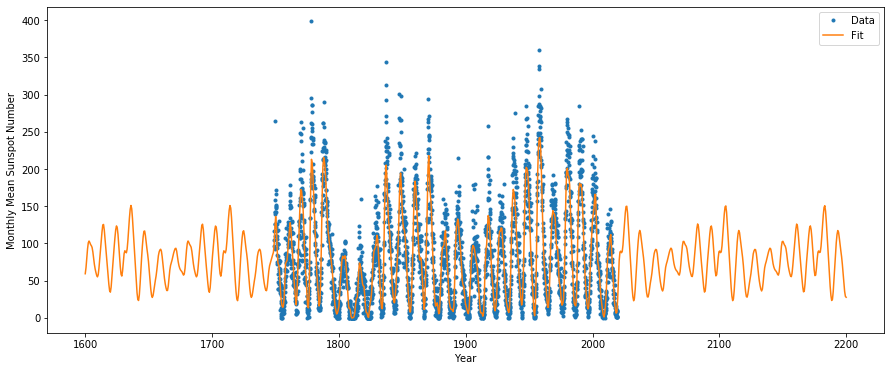

In [16]:
plot_svr()

### 2.2 Kernel Ridge Regression

Ridge regression is essentially fitting linear least squares but with an L2 regularisation penalty to help prevent overfitting. Kernerl ridge regression is the same but using the kernel trick to be able to fit non-linear functions.

In [17]:
krr = KernelRidge(kernel=ConstantKernel(constant_value=10)*(ExpSineSquared(length_scale=0.1, periodicity=1)+RBF(length_scale=0.01)))

In [18]:
krr.fit(time_ss, ss_number)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=3.16**2 * ExpSineSquared(length_scale=0.1, periodicity=1) + RBF(length_scale=0.01),
            kernel_params=None)

In [19]:
curve_fit_k = krr.predict(inf_ss)

In [20]:
def plot_krr():
    plt.figure(figsize=(15,6))
    plt.plot(time,ss_number,".")
    plt.plot(inf, curve_fit_k)
    plt.legend(labels=["Data", "Kernel Ridge Regression"])
    plt.ylabel("Monthly Mean Sunspot Number")
    plt.xlabel("Year");

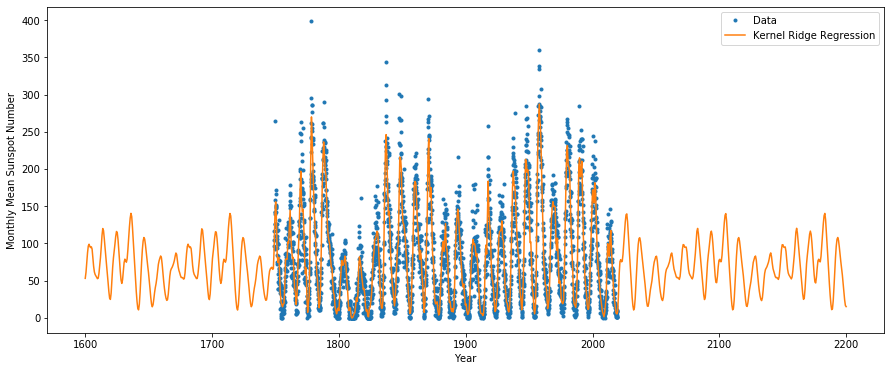

In [21]:
plot_krr()

A comparison of methods:

In [22]:
def plot_comp():
    plt.figure(figsize=(15,6))
    plt.plot(time,ss_number,".")
    plt.plot(inf, curve_fit_k)
    plt.plot(inf, curve_fit)
    plt.legend(labels=["Data", "Kernel Ridge Regression", "SVM"])
    plt.ylabel("Monthly Mean Sunspot Number")
    plt.xlabel("Year");

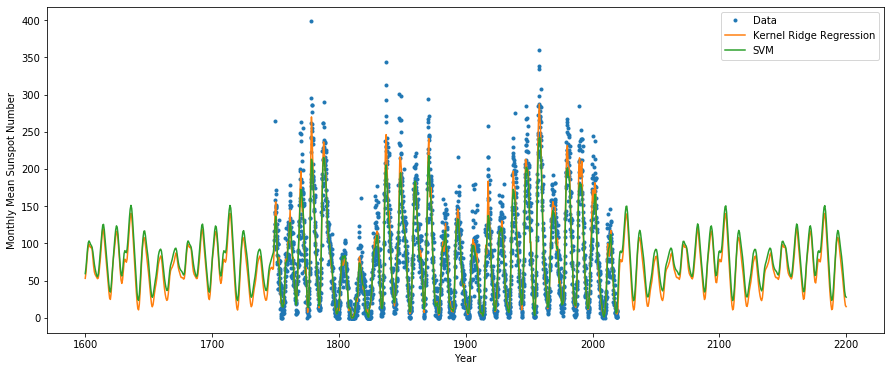

In [23]:
plot_comp()

## 3. Neural Networks with PyTorch

The following section will look at building neural networks with the deep learning framework `PyTorch`.

Torch has its own built-in maths library similar to numpy called **torch tensors**. These torch tensors are used as inputs and outputs to the neural networks built with Torch. They can be easily converted from (using the `torch.from_numpy` function) and to (using the `.numpy()` class method) numpy arrays.

In [24]:
a = np.zeros(4)
b = torch.from_numpy(a)
c = b.numpy()
print(type(a), type(b), type(c))

<class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


### 3.1 Building a Neural Network with PyTorch

Building a network in PyTorch is like using Lego: we fit the pieces together to become a whole end-to-end network. This is encapsulated by the class `Module` from `torch.nn` library.

`Module` is the skeleton class for all networks in PyTorch. A neural network class should always inherit the `Module` class as it comes with useful methods and the all-important `forward` method which is how the data is passed through the network.

We will build a simple fully-connected model to try and predict the sunspot number.

In [25]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(116, 1000)
        self.fc1b = nn.Linear(1000,1000)
        self.fc2 = nn.Linear(1000, 116)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc1b(out))
        return self.fc2(out)

Where here `nn.Linear` denotes a fully-connected layer in our neural network and after each layer we use the rectified linear unit (ReLU) non-linearity which can be described by

$$ \phi (x) = \text{max} (0, x) $$

![](Pictures/mlhelio_fc.png)

This is what our neural network looks like. We now need to train the network on our data.

### 3.2 Training a Neural Network in PyTorch

Torch does not come with prebuilt methods like `.fit` in `scitkit-learn`. As a result, we need to build our training and validation functions and give the network the data in a format it understands.

With Torch we utilise the `Dataset` and `DataLoader` classes.

* `Dataset` will allow us to format our dataset in a Torch-friendly manner e.g. in terms of Torch tensors.
* `DataLoader` will allow us to pass the data to the neural network in a sensible manner.

In particular, we use what is known as a `TensorDataset` in PyTorch to store our data. This is essentially just multiple tensors stored in the one object so we have one tensor for inputs and another for outputs.

Next we will split our data into a training and validation set. This is beneficial in ML as the validation set contains examples with known answers but the computer has never seen before. This gives a good metric for measuring the capabilities of a network.

In [26]:
times_rs = time_ss.reshape(-1,116)

In [27]:
ss_number_rs = ss_number.reshape(-1,116)

In [28]:
train_dataset = TensorDataset(torch.from_numpy(times_rs)[:-2], torch.from_numpy(ss_number_rs)[:-2])
val_dataset = TensorDataset(torch.from_numpy(times_rs)[-2:], torch.from_numpy(ss_number_rs)[-2:])

Now we create data loaders. This is an object that passes data to the network in batches. This is particularly important on GPUs where the I/O may be the bottleneck of your system.

In [29]:
train_loader, val_loader = DataLoader(train_dataset, batch_size=64, shuffle=False), DataLoader(val_dataset, batch_size=64, shuffle=False)

Now we have preprocessed our data and can begin to train our network. For training, we must define four things: the number of epochs to train, the learning rate of the system, the optimiser for learning, and the loss function to optimise.

In [33]:
fcn = FCN()
n_epochs = 100
lr = 0.005
optimiser = optim.Adam(fcn.parameters(), lr=lr)
loss = nn.MSELoss()

where we have chosen to use Adam which is a first order gradient descent method used for quick and accurate optimisation and uses momentum based on the first and second moments of the gradients.

We are now in a position to train our network.

In [34]:
for j in range(n_epochs):
    fcn.train()
    for inp, out in train_loader:
        inp, out = inp.float(), out.float()
        optimiser.zero_grad()
        model = fcn(inp)
        l = loss(model, out)
        l.backward()
        optimiser.step()
        
    fcn.eval()
    losses = []
    with torch.no_grad():
        for inp, out in val_loader:
            inp, out = inp.float(), out.float()
            model = fcn(inp)
            l = loss(model, out)
            losses.append(l)
            
    print("The validation loss are epoch "+str(j)+" is "+str(np.mean(losses)))

The validation loss are epoch 0 is 6659.516
The validation loss are epoch 1 is 4512.9995
The validation loss are epoch 2 is 4027.287
The validation loss are epoch 3 is 25101.41
The validation loss are epoch 4 is 27011.883
The validation loss are epoch 5 is 14968.735
The validation loss are epoch 6 is 8493.242
The validation loss are epoch 7 is 6935.0967
The validation loss are epoch 8 is 7713.5576
The validation loss are epoch 9 is 10506.571
The validation loss are epoch 10 is 15989.74
The validation loss are epoch 11 is 23347.82
The validation loss are epoch 12 is 27497.014
The validation loss are epoch 13 is 24896.371
The validation loss are epoch 14 is 19081.797
The validation loss are epoch 15 is 14404.3955
The validation loss are epoch 16 is 12052.129
The validation loss are epoch 17 is 11508.858
The validation loss are epoch 18 is 12336.08
The validation loss are epoch 19 is 14460.595
The validation loss are epoch 20 is 17659.955
The validation loss are epoch 21 is 20706.768
The 

Now it is time to fit the model to the data to see how well it does.

In [35]:
with torch.no_grad():
    curve_fit = fcn(torch.from_numpy(times_rs).float().unsqueeze(0)).numpy()

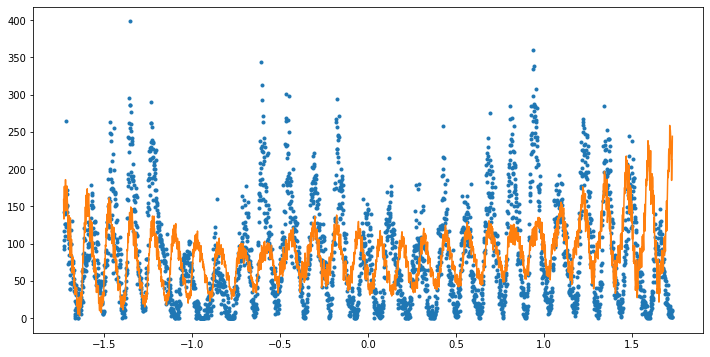

In [36]:
plt.figure(figsize=(12,6))
plt.plot(time_ss, ss_number, ".")
plt.plot(time_ss, curve_fit.reshape(3248))